### Sample: WaveFront support, all in Java

First, set the classpath with the right jar. This `jar` contains the statistical functions, system resolution and other linear algebra features, as well as the graphic library we use to display the curves.

This jar is built from the root of this repository, using the following command:
```
$ ./gradlew shadowJar --parallel
```

In [1]:
%classpath add jar "../build/libs/Algebra-1.0-all.jar"

In [2]:
// Verify if the classpath above is taken in account
import gsg.SwingUtils.Box3D;
import gsg.VectorUtils;
import gsg.WaveFrontUtils;

import javax.swing.*;
import java.awt.*;
import java.awt.event.ActionEvent;
import java.util.function.Consumer;
import java.util.function.Function;

Where we are:

In [3]:
System.out.println(String.format("Running from folder %s", System.getProperty("user.dir")));
System.out.println(String.format("Java version %s", System.getProperty("java.version")));

Running from folder /Users/olivierlediouris/repos/raspberry-coffee/Algebra/jupyter
Java version 11.0.8


### Prepare WaveFront data, from the `obj` file.

In [4]:
private final static String OBJ_FILE_NAME = "../wavefront/Trimaran.obj";

File file = new File(OBJ_FILE_NAME);
WaveFrontUtils.WaveFrontObj obj;
if (!file.exists()) {
    System.out.println("File not found, Oops...");
}

obj = WaveFrontUtils.parseWaveFrontObj(new BufferedReader(new FileReader(file)));
// Count artifacts:
System.out.printf("%d vertices, %d lines\n", obj.getVertices().size(), obj.getLines().size());

// Find extrema, to center the figure
double maxX = obj.getVertices().stream().mapToDouble(v3d -> v3d.getX()).max().getAsDouble();
double minX = obj.getVertices().stream().mapToDouble(v3d -> v3d.getX()).min().getAsDouble();
double maxY = obj.getVertices().stream().mapToDouble(v3d -> v3d.getY()).max().getAsDouble();
double minY = obj.getVertices().stream().mapToDouble(v3d -> v3d.getY()).min().getAsDouble();
double maxZ = obj.getVertices().stream().mapToDouble(v3d -> v3d.getZ()).max().getAsDouble();
double minZ = obj.getVertices().stream().mapToDouble(v3d -> v3d.getZ()).min().getAsDouble();

System.out.println("Extrema:");
System.out.printf("X in [%f, %f]\n", minX, maxX);
System.out.printf("Y in [%f, %f]\n", minY, maxY);
System.out.printf("Z in [%f, %f]\n", minZ, maxZ);

// Use the re-centerer to slide the object in its referential.
VectorUtils.Vector3D recenterer = new VectorUtils.Vector3D(-(maxX - minX) / 2, 0, 0);


1419 vertices, 1229 lines
Extrema:
X in [0.000000, 9140.000000]
Y in [-3800.000000, 3800.000000]
Z in [-500.000000, 1108.500000]


### Now create a 3D box, with several non-default options
The eye/camera is looking at the point `(0, 0, 0)`, its position is defined in the code of `Box3D` by
```
    private double rotOnZ =  40d;
    private double rotOnY =   0d;
    private double rotOnX = -10d;
```
Those parameters have getters and setters.

In [5]:
Box3D box3D = new Box3D();

box3D.setxMin(minX -(maxX - minX) / 2);
box3D.setxMax(maxX -(maxX - minX) / 2);
box3D.setyMin(minY);
box3D.setyMax(maxY);
box3D.setzMin(minZ);
box3D.setzMax(maxZ);


// Do something smart here.
Consumer<Graphics2D> afterDrawer = g2d -> {
    g2d.setStroke(new BasicStroke(1));

    obj.getLines().forEach(line -> {
        int from = line[0] - 1;  // Warning: those indexes are 1-based, not 0.
        int to = line[1] - 1;
        try {
            VectorUtils.Vector3D fromV3Rotated = VectorUtils.rotate(VectorUtils.add3D(Arrays.asList(obj.getVertices().get(from), recenterer)),
                    Math.toRadians(box3D.getRotOnX()),
                    Math.toRadians(box3D.getRotOnY()),
                    Math.toRadians(box3D.getRotOnZ()));
            VectorUtils.Vector3D toV3Rotated = VectorUtils.rotate(VectorUtils.add3D(Arrays.asList(obj.getVertices().get(to), recenterer)),
                    Math.toRadians(box3D.getRotOnX()),
                    Math.toRadians(box3D.getRotOnY()),
                    Math.toRadians(box3D.getRotOnZ()));
            Function<VectorUtils.Vector3D, Point> transformer = box3D.getTransformer();
            Point fromPoint = transformer.apply(fromV3Rotated);
            Point toPoint = transformer.apply(toV3Rotated);
            g2d.drawLine(fromPoint.x, fromPoint.y, toPoint.x, toPoint.y);
        } catch (IndexOutOfBoundsException ioobe) { // Error in the obj.
            ioobe.printStackTrace();
        }
    });

    g2d.setFont(g2d.getFont().deriveFont(Font.BOLD | Font.ITALIC, 24f));
    g2d.setColor(new Color(106, 86, 205));
    g2d.drawString(OBJ_FILE_NAME,10, 18 + 32);
};
box3D.setAfterDrawer(afterDrawer);

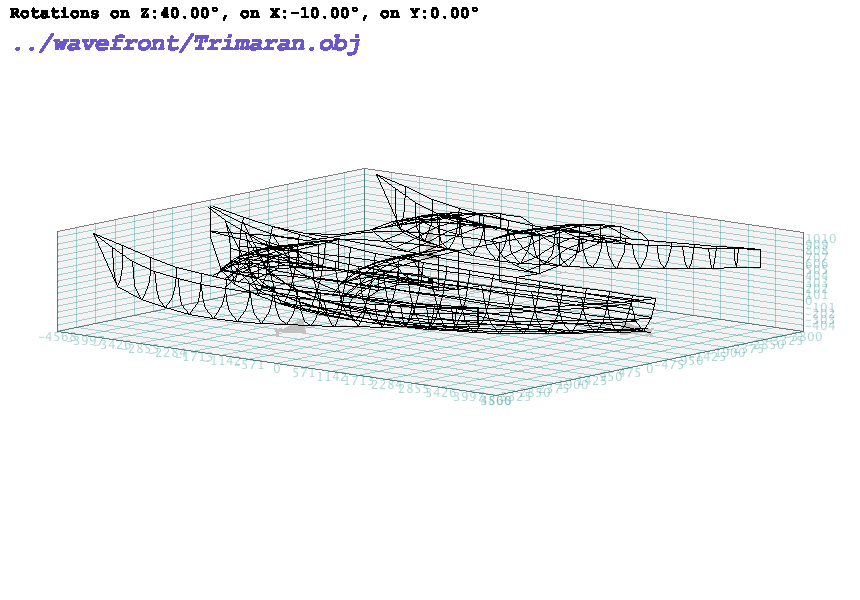

In [6]:
box3D.getImage();

Change rotation angles, re-display

In [7]:
box3D.setRotOnZ(50d);
box3D.setRotOnX(-20d);

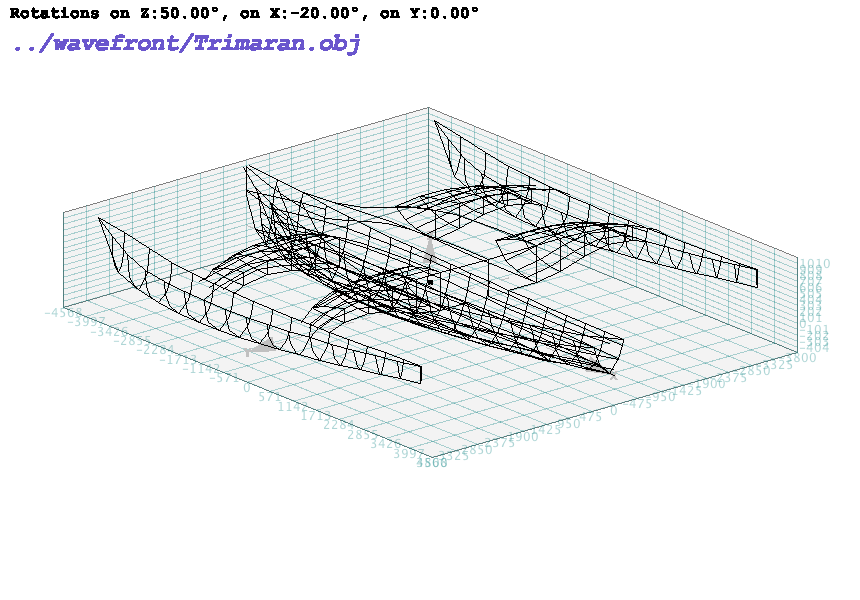

In [8]:
box3D.getImage();

Remove un-wanted artifacts

In [9]:
box3D.setWithAxis(false);
box3D.setWithBoxFaces(false);
box3D.setRotOnX(20d);

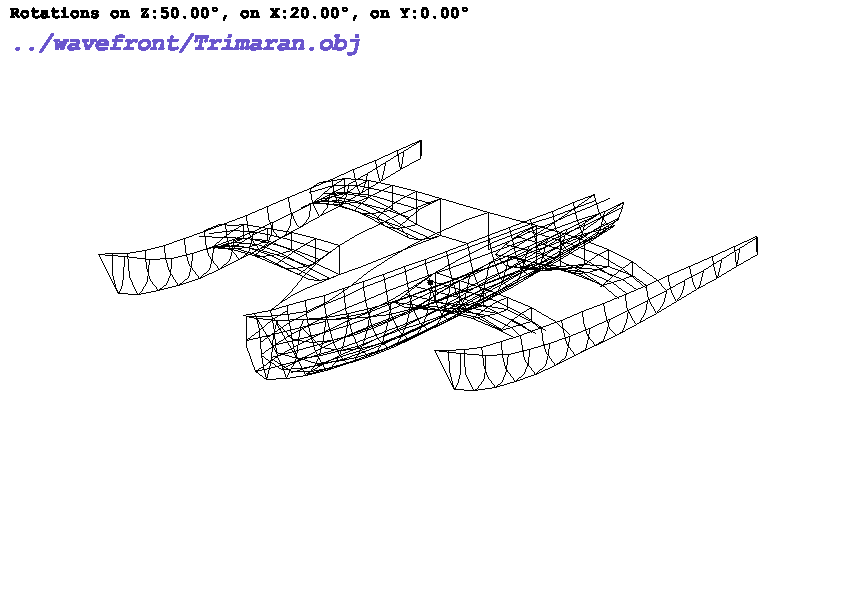

In [10]:
box3D.getImage();

---